# Machine Learning for Optical Network Security Monitoring: A Practical Perspective

This file contains the plots used in the paper as well as some plots used during the development of the paper.
<p style='color: red'>Note that the dataset is not made available due to confidentiality agreements in place.</p>

In the experiments, we evaluate a few settings:

The dataset configuration with three different options:
- **FD**: Using the full dataset (single dataset for path 1 and path 2) to train a single ANN without specifying which samples comes from which path (we do not have one-hot information for the path).
- **P1** and **P2**: Training the ANN for a single path (two ANNs, one for each path).
- **OH**: Using the full dataset to train a single ANN specifying the path which a sample comes from (including two one-hot columns for the path identification).

The ANN architecture:
- The ANN architecture, defined as the number of layers and number of neurons at each layer.

In the paper, we selected the ANN architecture [50, 100, 50] as the best one, and the full dataset including the one-hot columns identifying the lightpath as the best option.

For the unsupervised learning strategy (DBSCAN - [see documentation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)) we evaluate the impact of the following configuration parameters to the accuracy:
- $\epsilon$: The maximum distance between two samples for one to be considered as in the neighborhood of the other. This is not a maximum bound on the distances of points within a cluster.
- $MinPts$: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point.

For the semi-supervised learning strategy (OCSVM - [see documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html)) we evaluate the following configuration parameters:
- Kernel: rbf, linear, sigmoid, poly.
- $\gamma$: kernel coefficient.
- $\nu$: An upper bound on the fraction of training errors and a lower bound of the fraction of support vectors.

In [1]:
import pickle
import itertools

import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np

from sklearn.metrics import auc

from IPython import display

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

figure_format = 'svg'

## Style definition

In [2]:
base_alpha = .4
alpha_diff = .6
mpl.rcParams['font.size'] = 12
mpl.rcParams['grid.linestyle'] = ':'
mpl.rcParams['lines.markersize'] = 8
mpl.rcParams['figure.figsize'] = (6, 4)

In [3]:
dataset_variants = ['oh', 'fd', 'p1', 'p2']

## Helper functions

In [4]:
def get_sorted_pairs_ocsvm(performance):
    '''
    returns a list of vectors sorted by the false positive rate
    '''
    values = sorted([performance[kernel][nu][gamma] for kernel in performance for nu in performance[kernel] for gamma in performance[kernel][nu]], key=lambda x: x['false_positive_rate'])
    return values

def get_sorted_pairs_dbscan(performance):
    values = sorted([performance[min_samples][epsilon] for min_samples in performance for epsilon in performance[min_samples]], key=lambda x: x['false_positive_rate'])
    return values

def get_curve(sorted_pairs):
    '''
    returns a list of points of the Pareto frontier of false positive and false negative rates
    '''
    curve_samples = []
    curve_fpr = []
    curve_fnr = []

    last_x = sorted_pairs[0]['false_positive_rate']
    last_y = sorted_pairs[0]['false_negative_rate']

    curve_samples.append(sorted_pairs[0])
    curve_fpr.append(last_x)
    curve_fnr.append(last_y)
    
    for p in sorted_pairs:
        if p['false_positive_rate'] > curve_fpr[-1] and p['false_negative_rate'] < curve_fnr[-1]:
            curve_samples.append(p)
            curve_fpr.append(p['false_positive_rate'])
            curve_fnr.append(p['false_negative_rate'])
    return curve_samples

## Importing dataset

Loading the dataset from the XLSX file, creating some columns and cleaning it using pandas.

<p style='color: red'>Note that the dataset is not made available due to confidentiality agreements in place.</p>

In [5]:
# import dataset
seed = 42
np.random.seed(seed)
number_epochs = 1000
folder = '/nobackup/carda/datasets/ml-simulation-optical/2019-ecoc-demo'
final_dataframe = None
file_names = ['BSL', 'INBMOD', 'INBSTRONG', 'OOBMOD', 'OOBSTRONG', 'POLMODbis', 'POLSTRONG']
class_names = ['BSL', 'INBLGT', 'INBSTR', 'OOBLGT', 'OOBSTR', 'POLLGT', 'POLSTR']
for path_e in [1, 2]:
    for idc, clazz in enumerate(file_names):
        print(path_e, clazz)
        dataframe = pd.read_excel(folder + "/" + clazz + '13' + str(path_e) + '.xlsx', 'risultati', header=[0])
        dataframe = dataframe.drop(['n', 'time stamp', 'BE-FEC', 'UBE-FEC', 'OFT', 'OFT-max', 'OFT-min'], axis=1) # removing unused features
        dataframe['path_1'] = 1 if path_e == 1 else 0
        dataframe['path_2'] = 1 if path_e == 2 else 0
        dataframe['attack'] = idc
        dataframe = dataframe[~dataframe.isin([np.nan, np.inf, -np.inf]).any(1)] # remove samples with missing data
        if final_dataframe is None:
            final_dataframe = dataframe
        else:
            final_dataframe = pd.concat([final_dataframe, dataframe], ignore_index=True)

1 BSL
1 INBMOD
1 INBSTRONG
1 OOBMOD
1 OOBSTRONG
1 POLMODbis
1 POLSTRONG
2 BSL
2 INBMOD
2 INBSTRONG
2 OOBMOD
2 OOBSTRONG
2 POLMODbis
2 POLSTRONG


In [6]:
# make sure that attack column is the last one
columns = list(final_dataframe.columns)
columns.remove('attack')
columns.append('attack')
final_dataframe = final_dataframe[columns]
final_dataframe.describe()

BER-FEC   BER-FEC-max   BER-FEC-min  BER-POST-FEC  \
count  19882.000000  19882.000000  19882.000000  19882.000000   
mean       0.012379      0.017101      0.010983      0.001574   
std        0.027561      0.067567      0.008499      0.003461   
min        0.002885      0.003119      0.002734      0.000000   
25%        0.006552      0.007758      0.005488      0.000000   
50%        0.012653      0.013216      0.012376      0.000000   
75%        0.014464      0.015115      0.014093      0.000718   
max        1.000000      1.000000      1.000000      0.015633   

       BER-POST-FEC-max  BER-POST-FEC-min     LOSS           OPR  \
count      19882.000000      19882.000000  19882.0  19882.000000   
mean           0.002586          0.000754      0.0    -10.556373   
std            0.005009          0.002118      0.0      0.353269   
min            0.000000          0.000000      0.0    -11.125000   
25%            0.000000          0.000000      0.0    -10.755000   
50%            0.000000          0.000000      0.0    -10.635000   
75%            0.000981          0.000110      0.0    -10.515000   
max            0.015634          0.015301      0.0     -9.485000   

            OPR-max       OPR-min  ...      OSNR-min          PDL  \
count  19882.000000  19882.000000  ...  19882.000000  19882.00000   
mean     -10.533733    -10.579093  ...     19.448328      0.60849   
std        0.353096      0.353207  ...      3.307222      0.68690   
min      -11.085000    -11.155000  ...      0.000000      0.00000   
25%      -10.725000    -10.775000  ...     19.169900      0.00000   
50%      -10.615000    -10.655000  ...     19.436800      1.00000   
75%      -10.495000    -10.535000  ...     21.212800      1.00000   
max       -9.455000     -9.495000  ...     22.369100      8.00000   

            PDL-max       PDL-min      Q-factor  Q-factor-max  Q-factor-min  \
count  19882.000000  19882.000000  19882.000000  19882.000000  19882.000000   
mean       0.934011      0.462780      7.143919      7.250221      6.895393   
std        1.041501      0.511276      0.787734      0.724563      1.292874   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      6.700000      6.800000      6.600000   
50%        1.000000      0.000000      6.900000      7.000000      6.900000   
75%        1.000000      1.000000      7.800000      8.000000      7.600000   
max        8.000000      5.000000      8.800000      8.800000      8.600000   

             path_1        path_2        attack  
count  19882.000000  19882.000000  19882.000000  
mean       0.500151      0.499849      3.001257  
std        0.500013      0.500013      2.003003  
min        0.000000      0.000000      0.000000  
25%        0.000000      0.000000      1.000000  
50%        1.000000      0.000000      3.000000  
75%        1.000000      1.000000      5.000000  
max        1.000000      1.000000      6.000000  

[8 rows x 34 columns]

In [7]:
# removing columns that do not need to be visualized, i.e., class, max and min features
to_drop = ['path_1', 'path_2', 'attack']
for column in final_dataframe.columns:
    if 'min' in column or 'max' in column:
        to_drop += [column]

In [8]:
# scaling the dataset
scaler = preprocessing.StandardScaler().fit(final_dataframe.drop(['path_1', 'path_2', 'attack'], axis=1))
x_scaled = scaler.transform(final_dataframe.drop(['path_1', 'path_2', 'attack'], axis=1))
scaled_final_dataframe = pd.DataFrame(x_scaled, index=final_dataframe.index, columns=final_dataframe.drop(['path_1', 'path_2', 'attack'], axis=1).columns)

scaled_final_dataframe['path_1'] = final_dataframe['path_1']
scaled_final_dataframe['path_2'] = final_dataframe['path_2']
scaled_final_dataframe['attack'] = final_dataframe['attack']

## Visualizing the scaled dataset

In [30]:
# Plotting the boxplot (illustrates the distributions present in each one of the features)
fig_size = (10, 6)
plt.figure(figsize=fig_size)
sns.boxplot(data=scaled_final_dataframe)
ticks = plt.xticks()
plt.xticks(ticks[0], ticks[1], rotation=90)
plt.ylabel('Monitored value')
plt.xlabel('OPM parameter')
plt.grid(False)
plt.tight_layout()
plt.savefig(f'./figures/boxplot-scaled.{figure_format}')
plt.show()
plt.close()

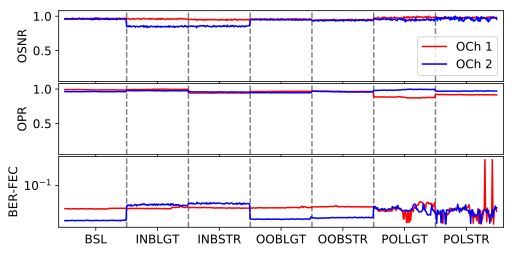

In [54]:
# visualizing three of the parameters
# Figure 8 of the paper
fig_kw = dict(figsize=(10,3))
f, ax = plt.subplots(3, 1, sharex=True, sharey=False, figsize=(8, 4), gridspec_kw=dict(wspace=0.0, hspace=.03))

for idc, clazz in enumerate(class_names):
    if idc > 0 and idc < len(class_names):
        ax[0].axvline(idc*100, linestyle='--', color='gray')
        ax[1].axvline(idc*100, linestyle='--', color='gray')
        ax[2].axvline(idc*100, linestyle='--', color='gray')

colors = ['red', 'blue']
for path_e in [1, 2]:
    final_osnr = None
    final_opr = None
    final_ber_post_fec = None
    for idc, clazz in enumerate(class_names):
        osnr = final_dataframe[(final_dataframe['attack'] == idc) & (final_dataframe[f'path_{path_e}'] == 1)]['OSNR'].values[:100]
        opr = final_dataframe[(final_dataframe['attack'] == idc) & (final_dataframe[f'path_{path_e}'] == 1)]['OPR'].values[:100]
        ber_post_fec = final_dataframe[(final_dataframe['attack'] == idc) & (final_dataframe[f'path_{path_e}'] == 1)]['BER-FEC'].values[:100*10]
        if final_osnr is None:
            final_osnr = osnr
            final_opr = opr
            final_ber_post_fec = ber_post_fec
        else:
            final_osnr = np.concatenate((final_osnr, osnr), axis=0)
            final_opr = np.concatenate((final_opr, opr), axis=0)
            final_ber_post_fec = np.concatenate((final_ber_post_fec, ber_post_fec), axis=0)
    
    plot_osnr = final_osnr / final_osnr.max()
    outliers = np.where(plot_osnr < 0.5)
    for outlier in outliers:
        plot_osnr[outlier] = plot_osnr[outlier-1]
    ax[0].plot(plot_osnr, label=f'OCh {path_e}', color=colors[path_e-1])
    ax[0].set_ylabel('OSNR')
    if path_e == 2:
        ax[0].legend(loc=4, fancybox=True, frameon=True)
    
    plot_opr = final_opr / final_opr.min()
    ax[1].plot(plot_opr, color=colors[path_e-1])
    ax[1].set_ylabel('OPR')
    
    plot_ber_post_fec = final_ber_post_fec
    ax[2].plot(plot_ber_post_fec[0::10], color=colors[path_e-1])
    ax[2].set_xticks([(idc*100)+50 for idc, clazz in enumerate(class_names)])
    ax[2].set_xticklabels([clazz for idc, clazz in enumerate(class_names)])
    ax[2].set_ylabel('BER-FEC')
    ax[2].set_yscale('log')
    

xlim = ax[2].get_ylim()
ax[0].set_ylim(xlim[0]+0.05, 1.08)
ax[1].set_ylim(xlim[0]+0.05, 1.08)
    
plt.xlim([-10, (idc+1)*100 + 10])
plt.savefig(f'./figures/thresholds.{figure_format}')
plt.show()

## Results for the supervised learning (ANN)

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title=None,
                          colorbar=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    It uses a figure previously opened, if any.
    After calling, the figure can be modified/finalized.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.nan_to_num(cm) # avoids NaN values

    # plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.pcolor(cm, cmap=cmap, edgecolors='white')
    if title is not None:
        plt.title(title)
    plt.gca().invert_yaxis()
    if colorbar:
        plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks + 0.5, classes, rotation=30)
    plt.yticks(tick_marks + 0.5, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if cm[i, j] == 0.0:
            text = '-'
        elif cm[i, j] == 1.0:
            text = '1.0'
        else:
            text = format(cm[i, j], fmt)
        plt.text(j + 0.5, i + 0.5, text,
                 horizontalalignment="center",
                 verticalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True attack')
    plt.xlabel('Predicted attack')

In [12]:
# loading the results
with open('./models/training_results.h5', 'rb') as f:
    data_ann = pickle.load(f)
with open('./models/cross_validation_results.h5', 'rb') as f:
    data_cv = pickle.load(f)

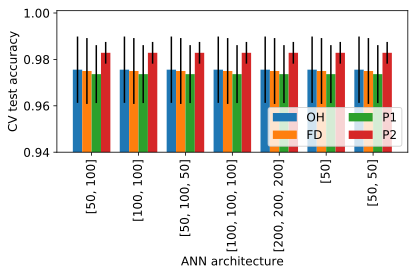

In [13]:
# plot for the CV results
results_cv_one_hot = data_cv['results_cv_one_hot']
results_cv_full_dataset = data_cv['results_cv_full_dataset']
results_cv_path_1 = data_cv['results_cv_path_1']
results_cv_path_2 = data_cv['results_cv_path_2']
layers_to_consider = data_cv['layers_to_consider']
plt.figure()

plt.bar([x - .3 for x in range(len(results_cv_one_hot))], 
        np.mean([results_cv_one_hot[x]['cross_validation']['test_balanced_accuracy'] for x in range(len(results_cv_one_hot))]), 
        yerr=np.std([results_cv_one_hot[x]['cross_validation']['test_balanced_accuracy'] for x in range(len(results_cv_one_hot))])/2,
        width=.2,
        label='OH')
plt.bar([x - .1 for x in range(len(results_cv_full_dataset))], 
        np.mean([results_cv_full_dataset[x]['cross_validation']['test_balanced_accuracy'] for x in range(len(results_cv_full_dataset))]), 
        yerr=np.std([results_cv_full_dataset[x]['cross_validation']['test_balanced_accuracy'] for x in range(len(results_cv_full_dataset))])/2, 
        width=.2,
        label='FD')
plt.bar([x + .1 for x in range(len(results_cv_path_1))], 
        np.mean([results_cv_path_1[x]['cross_validation']['test_balanced_accuracy'] for x in range(len(results_cv_path_1))]), 
        yerr=np.std([results_cv_path_1[x]['cross_validation']['test_balanced_accuracy'] for x in range(len(results_cv_path_1))])/2, 
        width=.2,
        label='P1')
plt.bar([x + .3 for x in range(len(results_cv_path_1))], 
        np.mean([results_cv_path_2[x]['cross_validation']['test_balanced_accuracy'] for x in range(len(results_cv_path_2))]), 
        yerr=np.std([results_cv_path_2[x]['cross_validation']['test_balanced_accuracy'] for x in range(len(results_cv_path_2))])/2, 
        width=.2,
        label='P2')

plt.xlabel('ANN architecture')
plt.xticks(range(len(results_cv_path_1)), [x for x in layers_to_consider], rotation=90)
plt.ylabel('CV test accuracy')
plt.ylim([0.94, 1.001])
plt.grid(False)

plt.legend(ncol=2, loc=4, frameon=True)
plt.tight_layout()
plt.savefig(f'./figures/ann_cv_test_accuracy.{figure_format}')
plt.show()
plt.close()

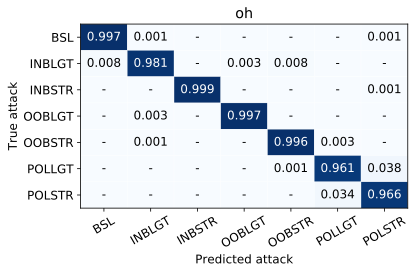

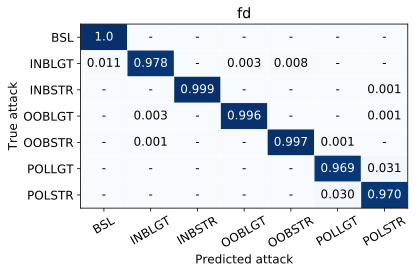

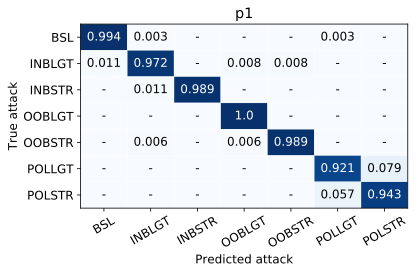

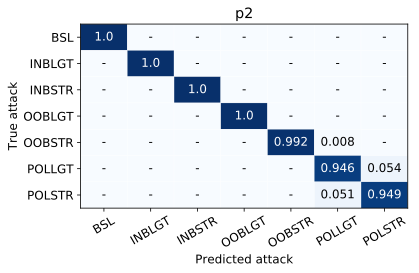

In [32]:
# confusion matrices of the test dataset
for _type in dataset_variants:
    plt.figure()
    plot_confusion_matrix(data_ann['cnf_matrix_test_'+_type], classes=data_ann['class_names'], normalize=True)
    plt.title(_type)
    plt.xlim([0, len(data_ann['class_names'])])
    plt.ylim([len(data_ann['class_names']), 0])
    plt.tight_layout()
    plt.savefig(f'./figures/confusion_matrix_test_{_type}.{figure_format}')
    plt.show()
    plt.close()

## Results for the semi-supervised learning (one-class support vector machine)

In [15]:
# loading the results
with open('./models/results_ocsvm.h5', 'rb') as f:
    data_ocsvm = pickle.load(f)
    performance_ocsvm_oh = data_ocsvm['performance_ocsvm_oh']
    performance_ocsvm_fd = data_ocsvm['performance_ocsvm_fd']
    performance_ocsvm_p1 = data_ocsvm['performance_ocsvm_p1']
    performance_ocsvm_p2 = data_ocsvm['performance_ocsvm_p2']

### Computing the best configuration for each variant based on the f1 score

In [16]:
best_configs_ocsvm = {}
best_f1_score_ocsvm = {}
best_rate_ocsvm = {}
for variant in dataset_variants:
    sorted_pairs = get_sorted_pairs_ocsvm(data_ocsvm['performance_ocsvm_'+variant])
    curve = get_curve(sorted_pairs)
    best_fpr = 1.
    best_fnr = 1.
    best_f1 = 0.
    for p in curve:
        fpr = p['false_positive_rate']
        fnr = p['false_negative_rate']
        precision = p['precision']
        recall = p['recall']
        f1 = p['f1_score']
        if f1 > best_f1:
            best_fpr = fpr
            best_fnr = fnr
            best_f1 = f1
    best_configs_ocsvm[variant] = []
    best_f1_score_ocsvm[variant] = best_f1
    best_rate_ocsvm[variant] = (best_fpr, best_fnr)
    for kernel in data_ocsvm['performance_ocsvm_'+variant]:
        for nu in data_ocsvm['performance_ocsvm_'+variant][kernel]:
            for gamma in data_ocsvm['performance_ocsvm_'+variant][kernel][nu]:
                if data_ocsvm['performance_ocsvm_'+variant][kernel][nu][gamma]['false_positive_rate'] == best_fpr and \
                    data_ocsvm['performance_ocsvm_'+variant][kernel][nu][gamma]['false_negative_rate'] == best_fnr:
                    best_configs_ocsvm[variant].append((kernel, gamma, nu))
    print(variant, '{:.3f}'.format(best_f1), best_rate_ocsvm[variant], [x for x in best_configs_ocsvm[variant]])

oh 0.963 (0.0183, 0.05450222222222222) [('linear', 0.1, 0.01)]
fd 0.960 (0.0192, 0.05831555555555556) [('linear', 0.1, 0.01)]
p1 0.898 (0.173, 0.04418666666666666) [('rbf', 0.5, 0.01)]
p2 0.967 (0.0204, 0.04462222222222222) [('linear', 1.0, 0.01)]


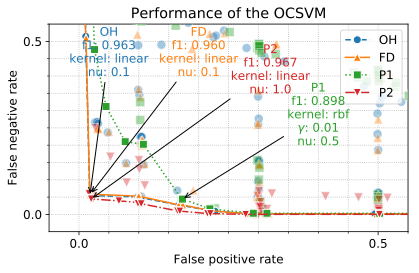

In [17]:
# plotting results
plt.figure()

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_oh)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='o', s=80, alpha=base_alpha, edgecolors='white', zorder=5)
plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], ls='--', marker='o', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='OH')
plt.annotate('OH\nf1: {0:.3f}\nkernel: {1}\nnu: {3}'.format(best_f1_score_ocsvm['oh'], best_configs_ocsvm['oh'][0][0], best_configs_ocsvm['oh'][0][2], best_configs_ocsvm['oh'][0][1]),
             xy=best_rate_ocsvm['oh'], xycoords='data',
             xytext=(.05, .4), textcoords='data',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
                zorder=20)

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_fd)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='^', s=80, alpha=base_alpha, edgecolors='white', zorder=5)
plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls='-', marker='^', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='FD')
plt.annotate('FD\nf1: {0:.3f}\nkernel: {1}\nnu: {3}'.format(best_f1_score_ocsvm['fd'], best_configs_ocsvm['fd'][0][0], best_configs_ocsvm['fd'][0][2], best_configs_ocsvm['fd'][0][1]),
             xy=best_rate_ocsvm['fd'], xycoords='data',
             xytext=(.2, .4), textcoords='data',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
                zorder=20)

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_p1)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='s', s=80, alpha=base_alpha, edgecolors='white', zorder=5)
plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls=':', marker='s', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='P1')
plt.annotate('P1\nf1: {0:.3f}\nkernel: {1}\n$\gamma$: {2}\nnu: {3}'.format(best_f1_score_ocsvm['p1'], best_configs_ocsvm['p1'][0][0], best_configs_ocsvm['p1'][0][2], best_configs_ocsvm['p1'][0][1]),
             xy=best_rate_ocsvm['p1'], xycoords='data',
             xytext=(.4, .2), textcoords='data',
             horizontalalignment='center',
             color=ax.get_facecolors()[0],alpha=1.,
             arrowprops=dict(arrowstyle='->'),
                zorder=20)

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_p2)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='v', s=80, alpha=base_alpha, edgecolors='white', zorder=5)
plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls='-.', marker='v', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='P2')
plt.annotate('P2\nf1: {0:.3f}\nkernel: {1}\nnu: {3}'.format(best_f1_score_ocsvm['p2'], best_configs_ocsvm['p2'][0][0], best_configs_ocsvm['p2'][0][2], best_configs_ocsvm['p2'][0][1]),
             xy=best_rate_ocsvm['p2'], xycoords='data',
             xytext=(.32, .35), textcoords='data',
             horizontalalignment='center',
             color=ax.get_facecolors()[0],alpha=1.,
             arrowprops=dict(arrowstyle='->'),
                zorder=20)

plt.title('Performance of the OCSVM')
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
plt.grid(True, which='both')
plt.xticks([0, .5, 1.])
plt.xlim([-0.05, 0.55])
plt.yticks([0, .5, 1.])
plt.ylim([-0.05, .55])
plt.gca().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(10))
plt.gca().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(10))
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'./figures/ocsvm_performance_linear.{figure_format}')
plt.show()
plt.close()

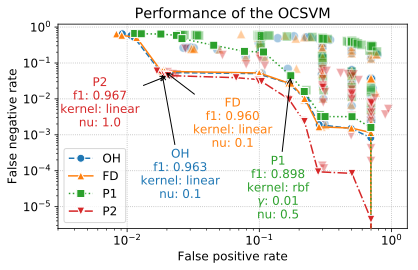

In [44]:
plt.figure()

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_oh)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='o', s=80, alpha=base_alpha, edgecolors='white', zorder=1)
plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls='--', marker='o', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='OH')
plt.annotate('OH\nf1: {0:.3f}\nkernel: {1}\nnu: {3}'.format(best_f1_score_ocsvm['oh'], best_configs_ocsvm['oh'][0][0], best_configs_ocsvm['oh'][0][2], best_configs_ocsvm['oh'][0][1]),
             xy=best_rate_ocsvm['oh'], xycoords='data',
             xytext=(.35, .15), textcoords='axes fraction',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
                zorder=20)

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_fd)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='^', s=80, alpha=base_alpha, edgecolors='white', zorder=1)
plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls='-', marker='^', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='FD')
plt.annotate('FD\nf1: {0:.3f}\nkernel: {1}\nnu: {3}'.format(best_f1_score_ocsvm['fd'], best_configs_ocsvm['fd'][0][0], best_configs_ocsvm['fd'][0][2], best_configs_ocsvm['fd'][0][1]),
             xy=best_rate_ocsvm['fd'], xycoords='data',
             xytext=(.5, .4), textcoords='axes fraction',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
                zorder=20)

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_p1)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='s', s=80, alpha=base_alpha, edgecolors='white', zorder=1)
plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls=':', marker='s', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='P1')
plt.annotate('P1\nf1: {0:.3f}\nkernel: {1}\n$\gamma$: {2}\nnu: {3}'.format(best_f1_score_ocsvm['p1'], best_configs_ocsvm['p1'][0][0], best_configs_ocsvm['p1'][0][2], best_configs_ocsvm['p1'][0][1]),
             xy=best_rate_ocsvm['p1'], xycoords='data',
             xytext=(.63, .05), textcoords='axes fraction',
             horizontalalignment='center',
             color=ax.get_facecolors()[0],alpha=1.,
             arrowprops=dict(arrowstyle='->'),
                zorder=20)

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_p2)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='v', s=80, alpha=base_alpha, edgecolors='white', zorder=1)
plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls='-.', marker='v', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='P2')
plt.annotate('P2\nf1: {0:.3f}\nkernel: {1}\nnu: {3}'.format(best_f1_score_ocsvm['p2'], best_configs_ocsvm['p2'][0][0], best_configs_ocsvm['p2'][0][2], best_configs_ocsvm['p2'][0][1]),
             xy=best_rate_ocsvm['p2'], xycoords='data',
             xytext=(.12, .5), textcoords='axes fraction',
             horizontalalignment='center',
             color=ax.get_facecolors()[0],alpha=1.,
             arrowprops=dict(arrowstyle='->'),
                zorder=20)

plt.title('Performance of the OCSVM')
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.grid(True, ls=':')
plt.legend(loc='lower left')
plt.tight_layout()
xlim = plt.xlim()
plt.xlim([3*1e-3, xlim[1]])
plt.savefig(f'./figures/ocsvm_performance_log.{figure_format}')
plt.show()
plt.close()

## Results for the unsupervised learning (DBSCAN)

In [19]:
# loading the results
with open('./models/results_dbscan.h5', 'rb') as f:
    data_dbscan = pickle.load(f)
    performance_dbscan_oh = data_dbscan['performance_dbscan_oh']
    performance_dbscan_fd = data_dbscan['performance_dbscan_fd']
    performance_dbscan_p1 = data_dbscan['performance_dbscan_p1']
    performance_dbscan_p2 = data_dbscan['performance_dbscan_p2']

### Computing the best configuration for each variant based on the f1 score

In [20]:
best_configs_dbscan = {}
best_f1_score_dbscan = {}
best_rate_dbscan = {}
for variant in dataset_variants:
    sorted_pairs = get_sorted_pairs_dbscan(data_dbscan['performance_dbscan_'+variant])
    curve = get_curve(sorted_pairs)
        
    best_fpr = 1.
    best_fnr = 1.
    best_f1 = 0.
    best_precision = 0.
    highest_precision = 0.
    best_recall = 0.
    highest_recall = 0.
    for p in curve:
        fpr = p['false_positive_rate']
        fnr = p['false_negative_rate']
        precision = p['precision']
        highest_precision = max(highest_precision, precision)
        recall = p['recall']
        highest_recall = max(highest_recall, recall)
        f1 = p['f1_score']
        if f1 > best_f1:
            best_fpr = fpr
            best_fnr = fnr
            best_f1 = f1
            best_precision = precision
            best_recall = recall
    
    best_configs_dbscan[variant] = []
    best_f1_score_dbscan[variant] = best_f1
    best_rate_dbscan[variant] = (best_fpr, best_fnr)
    for min_samples in data_dbscan['performance_dbscan_'+variant]:
        for epsilon in data_dbscan['performance_dbscan_'+variant][min_samples]:
            if data_dbscan['performance_dbscan_'+variant][min_samples][epsilon]['false_positive_rate'] == best_fpr and \
                     data_dbscan['performance_dbscan_'+variant][min_samples][epsilon]['false_negative_rate'] == best_fnr:
                best_configs_dbscan[variant].append((min_samples, epsilon))
    if variant is 'oh':
        for point in curve:
            if point['false_positive_rate'] < .46 and point['false_negative_rate'] > .073:
                extra_rate_dbscan = (point['false_positive_rate'], point['false_negative_rate'])
                print(point['false_positive_rate'], point['false_negative_rate'], point)
    for min_samples in data_dbscan['performance_dbscan_'+variant]:
        for epsilon in data_dbscan['performance_dbscan_'+variant][min_samples]:
            if data_dbscan['performance_dbscan_'+variant][min_samples][epsilon]['false_positive_rate'] == extra_rate_dbscan[0] and \
                     data_dbscan['performance_dbscan_'+variant][min_samples][epsilon]['false_negative_rate'] == extra_rate_dbscan[1]:
                extra_config_dbscan = (data_dbscan['performance_dbscan_'+variant][min_samples][epsilon]['f1_score'], min_samples, epsilon)

0.0 0.817191111111111 {'min_samples': 3, 'epsilon': 3.0, 'true_positive_rate': 0.18280888888888888, 'false_negative_rate': 0.817191111111111, 'true_negative_rate': 1.0, 'false_positive_rate': 0.0, 'precision': 0.35026666666666667, 'recall': 0.18280888888888888, 'f1_score': 0.22594373417438843}
0.0012683333333333333 0.6252933333333335 {'min_samples': 10, 'epsilon': 2.0, 'true_positive_rate': 0.3747066666666667, 'false_negative_rate': 0.6252933333333335, 'true_negative_rate': 0.9987316666666666, 'false_positive_rate': 0.0012683333333333333, 'precision': 0.8626190601981837, 'recall': 0.3747066666666667, 'f1_score': 0.42268188761584596}
0.0017196666666666662 0.4499555555555556 {'min_samples': 20, 'epsilon': 2.0, 'true_positive_rate': 0.5500444444444444, 'false_negative_rate': 0.4499555555555556, 'true_negative_rate': 0.9982803333333332, 'false_positive_rate': 0.0017196666666666662, 'precision': 0.9434080405004315, 'recall': 0.5500444444444444, 'f1_score': 0.6233029892159968}
0.008658 0.413

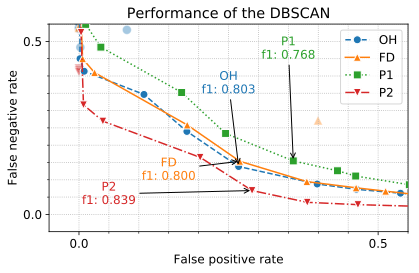

In [45]:
plt.figure()

sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_oh)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='o', s=80, alpha=base_alpha, edgecolors='white', zorder=1)
plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls='--', marker='o', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='OH')
plt.annotate('OH\nf1: {:.3f}'.format(best_f1_score_dbscan['oh']),
             xy=best_rate_dbscan['oh'], xycoords='data',
             xytext=(.25, .35), textcoords='data',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
                zorder=20)

sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_fd)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='^', s=80, alpha=base_alpha, edgecolors='white', zorder=1)
plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls='-', marker='^', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='FD')
plt.annotate('FD\nf1: {:.3f}'.format(best_f1_score_dbscan['fd']),
             xy=best_rate_dbscan['fd'], xycoords='data',
             xytext=(.15, .1), textcoords='data',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
                zorder=20)

sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_p1)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='s', s=80, alpha=base_alpha, edgecolors='white', zorder=1)
plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls=':', marker='s', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='P1')
plt.annotate('P1\nf1: {:.3f}'.format(best_f1_score_dbscan['p1']),
             xy=best_rate_dbscan['p1'], xycoords='data',
             xytext=(.35, .45), textcoords='data',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
                zorder=20)

sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_p2)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='v', s=80, alpha=base_alpha, edgecolors='white', zorder=1)
plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls='-.', marker='v', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='P2')
plt.annotate('P2\nf1: {:.3f}'.format(best_f1_score_dbscan['p2']),
             xy=best_rate_dbscan['p2'], xycoords='data',
             xytext=(.05, .03), textcoords='data',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
                zorder=20)

plt.title('Performance of the DBSCAN')
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
plt.grid(True, which='both')
plt.xticks([0, .5, 1.])
plt.xlim([-0.05, .55])
plt.yticks([0, .5, 1.])
plt.ylim([-0.05, .55])
plt.gca().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(10))
plt.gca().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(10))
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'./figures/dbscan_performance_linear.{figure_format}')
plt.show()
plt.close()

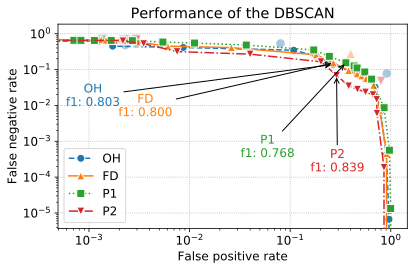

In [51]:
plt.figure()

sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_oh)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='o', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls='--', marker='o', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='OH')
plt.annotate('OH\nf1: {:.3f}'.format(best_f1_score_dbscan['oh']),
             xy=best_rate_dbscan['oh'], xycoords='data',
             xytext=(.1, .6), textcoords='axes fraction',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
                zorder=20)

sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_fd)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='^', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls='-', marker='^', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='FD')
plt.annotate('FD\nf1: {:.3f}'.format(best_f1_score_dbscan['fd']),
             xy=best_rate_dbscan['fd'], xycoords='data',
             xytext=(.25, .55), textcoords='axes fraction',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
                zorder=20)

sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_p1)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='s', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls=':', marker='s', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='P1')
plt.annotate('P1\nf1: {:.3f}'.format(best_f1_score_dbscan['p1'], best_configs_dbscan['p1'][0][0], best_configs_dbscan['p1'][0][1]), #\nminPts: {}\n$\epsilon$: {}
             xy=best_rate_dbscan['p1'], xycoords='data',
             xytext=(.6, .35), textcoords='axes fraction',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
                zorder=20)

sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_p2)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='v', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls='-.', marker='v', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='P2')

plt.annotate('P2\nf1: {:.3f}'.format(best_f1_score_dbscan['p2'], best_configs_dbscan['p2'][0][0], best_configs_dbscan['p2'][0][1]), #\nminPts: {}\n$\epsilon$: {}
             xy=best_rate_dbscan['p2'], xycoords='data',
             xytext=(.8, .28), textcoords='axes fraction',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
                zorder=20)

plt.title('Performance of the DBSCAN')
plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
plt.grid(True)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(f'./figures/dbscan_performance_log.{figure_format}')
plt.show()
plt.close()

## Graphs combining supervised, semi-supervised and unsupervised learning results

OCSVM: (0.0183, 0.05450222222222222)
DBSCAN: (0.266828, 0.1383711111111111)
DBSCAN: (0.39816633333333334, 0.08776666666666667)


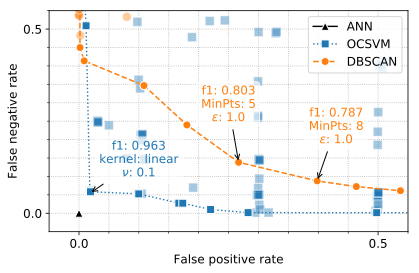

In [55]:
plt.figure()

plt.plot(0, 0, 
         ls='-', marker='^', alpha=base_alpha+alpha_diff, markeredgecolor='white', color='black', zorder=10, 
         label='ANN', linewidth=1.4)

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_fd)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='s', s=80, alpha=base_alpha, edgecolors='white', zorder=5)
plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls=':', marker='s', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, 
         label='OCSVM', linewidth=1.4)
plt.annotate('f1: {0:.3f}\nkernel: {1}\n$\\nu$: {3}'.format(best_f1_score_ocsvm['oh'], best_configs_ocsvm['oh'][0][0], best_configs_ocsvm['oh'][0][2], best_configs_ocsvm['oh'][0][1]),
             xy=best_rate_ocsvm['oh'], xycoords='data',
             xytext=(.1, .1), textcoords='data',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
             bbox=dict(boxstyle='round', ec=(1., 1., 1., .8), fc=(1., 1., 1., .6)),
                zorder=20)
print('OCSVM:', best_rate_ocsvm['oh'])

sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_oh)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='o', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls='--', marker='o', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='DBSCAN')
plt.annotate('f1: {:.3f}\nMinPts: {}\n$\epsilon$: {}'.format(best_f1_score_dbscan['oh'], best_configs_dbscan['oh'][0][0], best_configs_dbscan['oh'][0][1]),
             xy=best_rate_dbscan['oh'], xycoords='data',
             xytext=(.5, .5), textcoords='axes fraction',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
             bbox=dict(boxstyle='round', ec=(1., 1., 1., .8), fc=(1., 1., 1., .6)),
                zorder=20)
print('DBSCAN:', best_rate_dbscan['oh'])

plt.annotate('f1: {:.3f}\nMinPts: {}\n$\epsilon$: {}'.format(extra_config_dbscan[0], extra_config_dbscan[1], extra_config_dbscan[2]),
             xy=extra_rate_dbscan, xycoords='data',
             xytext=(.8, .4), textcoords='axes fraction',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
             bbox=dict(boxstyle='round', ec=(1., 1., 1., .8), fc=(1., 1., 1., .6)),
                zorder=20)
print('DBSCAN:', extra_rate_dbscan)

plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
plt.grid(True, which='both')
plt.xticks([0, .5, 1.])
plt.xlim([-0.05, 0.55])
plt.yticks([0, .5, 1.])
plt.ylim([-0.05, .55])
plt.gca().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(10))
plt.gca().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(10))
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'./figures/sl_ssl_ul_performance_linear.{figure_format}')
plt.show()
plt.close()

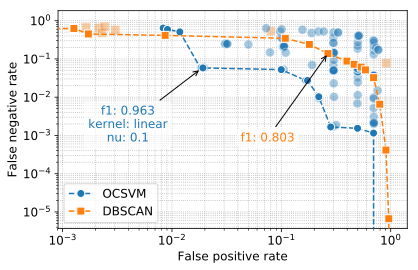

In [25]:
plt.figure()

sorted_pairs = get_sorted_pairs_ocsvm(performance_ocsvm_fd)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='o', s=80, alpha=base_alpha, edgecolors='white', zorder=5)
plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], ls='--', marker='o', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='OCSVM')
plt.annotate('f1: {0:.3f}\nkernel: {1}\nnu: {3}'.format(best_f1_score_ocsvm['oh'], best_configs_ocsvm['oh'][0][0], best_configs_ocsvm['oh'][0][2], best_configs_ocsvm['oh'][0][1]),
             xy=best_rate_ocsvm['oh'], xycoords='data',
             xytext=(.2, .4), textcoords='axes fraction',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
             bbox=dict(boxstyle='round', ec=(1., 1., 1., .8), fc=(1., 1., 1., .6)),
                zorder=20)

sorted_pairs = get_sorted_pairs_dbscan(performance_dbscan_oh)
curve = get_curve(sorted_pairs)
ax = plt.scatter([c['false_positive_rate'] for c in sorted_pairs if c not in curve],
           [c['false_negative_rate'] for c in sorted_pairs if c not in curve],
           marker='s', s=80, alpha=base_alpha, edgecolors='white', zorder=1)

plt.plot([c['false_positive_rate'] for c in curve], [c['false_negative_rate'] for c in curve], 
         ls='--', marker='s', alpha=base_alpha+alpha_diff, markeredgecolor='white', color=ax.get_facecolors()[0], zorder=10, label='DBSCAN')
plt.annotate('f1: {:.3f}'.format(best_f1_score_dbscan['oh']),
             xy=best_rate_dbscan['oh'], xycoords='data',
             xytext=(.6, .4), textcoords='axes fraction',
             horizontalalignment='center',
             color=ax.get_facecolors()[0], alpha=1.,
             arrowprops=dict(arrowstyle='->'),
             bbox=dict(boxstyle='round', ec=(1., 1., 1., .8), fc=(1., 1., 1., .6)),
                zorder=20)

plt.xlabel('False positive rate')
plt.ylabel('False negative rate')
plt.grid(True, which='both')
plt.gca().xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(10))
plt.gca().yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(10))
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.legend(loc='lower left')
plt.tight_layout()
plt.savefig(f'./figures/ssl_ul_performance_log.{figure_format}')
plt.show()
plt.close()